 100% |█████████████████| 287/287 [3.9s elapsed, 0s remaining, 88.2 samples/s]      



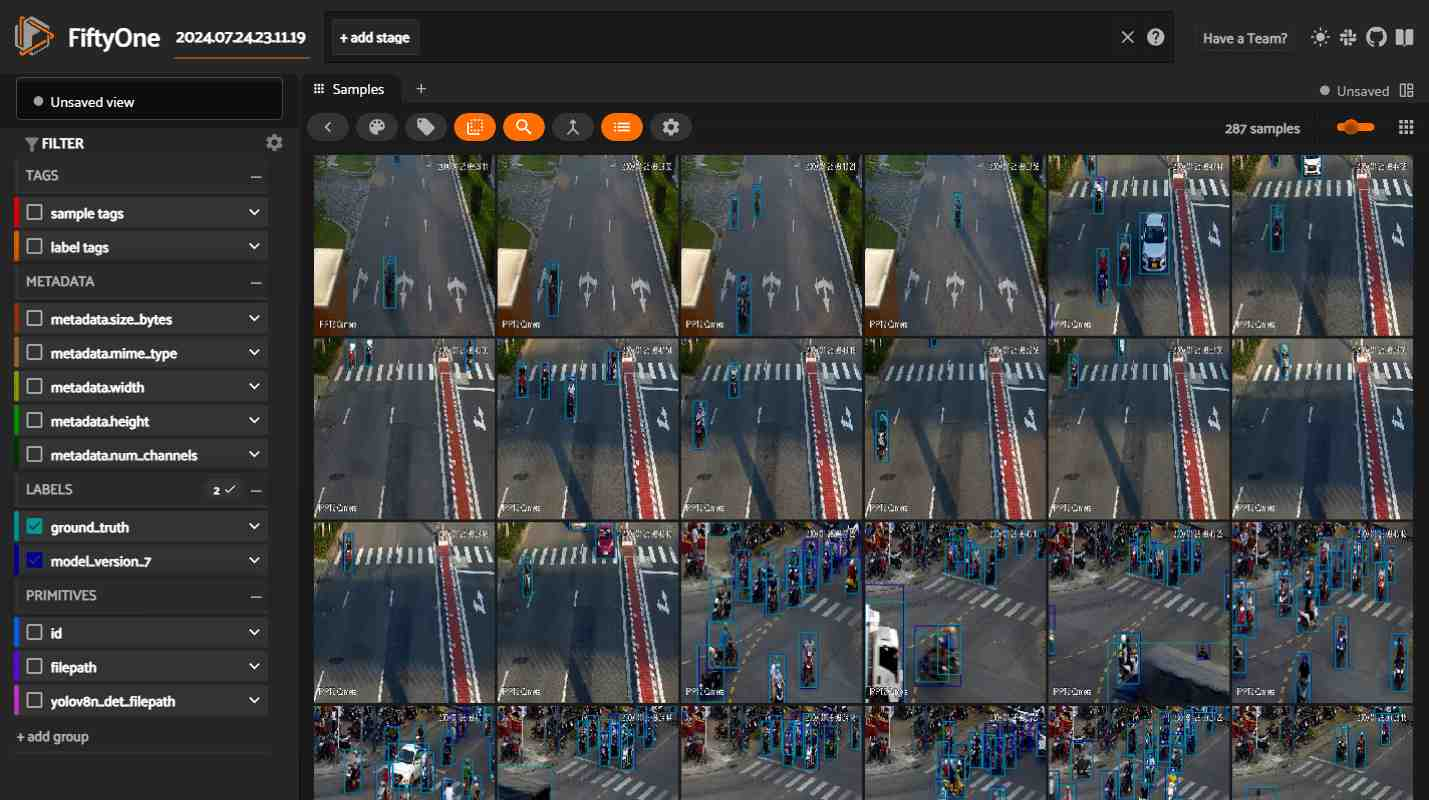

Notebook sessions cannot wait


In [19]:
import fiftyone as fo
import numpy as np
import os


def read_yolo_detections_file(filepath):
    detections = []
    if not os.path.exists(filepath):
        return np.array([])

    with open(filepath) as f:
        lines = [line.rstrip('\n').split(' ') for line in f]

    for line in lines:
        detection = [float(l) for l in line]
        detections.append(detection)
    return np.array(detections)


def _uncenter_boxes(boxes):
    '''convert from center coords to corner coords'''
    boxes[:, 0] -= boxes[:, 2]/2.
    boxes[:, 1] -= boxes[:, 3]/2.


def _get_class_labels(predicted_classes, class_list):
    labels = (predicted_classes).astype(int)
    labels = [class_list[l] for l in labels]
    return labels


def convert_yolo_detections_to_fiftyone(
    yolo_detections,
    class_list
):

    detections = []
    if yolo_detections.size == 0:
        return fo.Detections(detections=detections)

    boxes = yolo_detections[:, 1:-1]
    _uncenter_boxes(boxes)

    confs = yolo_detections[:, -1]
    labels = _get_class_labels(yolo_detections[:, 0], class_list)

    for label, conf, box in zip(labels, confs, boxes):
        detections.append(
            fo.Detection(
                label=label,
                bounding_box=box.tolist(),
                confidence=conf
            )
        )

    return fo.Detections(detections=detections)


def get_prediction_filepath(filepath, result_prediction_path, run_number=1, ):
    run_num_string = ""
    if run_number != 1:
        run_num_string = str(run_number)
    filename = filepath.split("/")[-1].rsplit(".", 1)[0]
    return f"{result_prediction_path}/{filename}.txt"


def add_yolo_detections(
    samples,
    prediction_field,
    prediction_filepath,
    class_list
):

    prediction_filepaths = samples.values(prediction_filepath)
    yolo_detections = [read_yolo_detections_file(
        pf) for pf in prediction_filepaths]
    detections = [convert_yolo_detections_to_fiftyone(
        yd, class_list) for yd in yolo_detections]
    samples.set_values(prediction_field, detections)


# Define the paths to the dataset
dataset_dir = "dataset/valid"
data_path = f"{dataset_dir}/images"
labels_path = f"{dataset_dir}/labels"
result_prediction_path = f"{dataset_dir}/prediction"
name_prediction = "model_version_7"
classes = ["4_wheel_vehicle", "face", "2_wheel_vehicle"]

# Load the dataset
dataset = fo.Dataset.from_dir(
    dataset_type=fo.types.YOLOv4Dataset,
    data_path=data_path,
    labels_path=labels_path,
    classes = ["4_wheel_vehicle", "face", "2_wheel_vehicle"]
)

filepaths = dataset.values("filepath")
# For each file path, replace \\ to /
filepaths = [fp.replace("\\", "/") for fp in filepaths]
prediction_filepaths = [get_prediction_filepath(
    fp, result_prediction_path=result_prediction_path) for fp in filepaths]
dataset.set_values(
    "yolov8n_det_filepath",
    prediction_filepaths
)

add_yolo_detections(
    dataset,
    name_prediction,
    "yolov8n_det_filepath",
    classes
)

session = fo.launch_app(dataset)
session.wait()

In [14]:
print(dataset.first().ground_truth)


<Detections: {
    'detections': [
        <Detection: {
            'id': '66a11f3b99472030727ebf57',
            'attributes': {},
            'tags': [],
            'label': '2',
            'bounding_box': [0.384765625, 0.558203125, 0.06640625, 0.28515625],
            'mask': None,
            'confidence': None,
            'index': None,
            'eval': 'fn',
            'eval_id': '',
        }>,
        <Detection: {
            'id': '66a11f3b99472030727ebf58',
            'attributes': {},
            'tags': [],
            'label': '2',
            'bounding_box': [0.43671875, 0.0, 0.040625, 0.0484375],
            'mask': None,
            'confidence': None,
            'index': None,
            'eval': 'fn',
            'eval_id': '',
        }>,
        <Detection: {
            'id': '66a11f3b99472030727ebf59',
            'attributes': {},
            'tags': [],
            'label': '1',
            'bounding_box': [0.416015625, 0.577734375, 0.01484375, 0.0210

In [23]:
print(dataset.first().model_version_7)


<Detections: {
    'detections': [
        <Detection: {
            'id': '66a127ab99472030727f8028',
            'attributes': {},
            'tags': [],
            'label': '2_wheel_vehicle',
            'bounding_box': [0.3845412, 0.5582015, 0.0675056, 0.283545],
            'mask': None,
            'confidence': 0.899502,
            'index': None,
            'eval': 'tp',
            'eval_id': '66a127a799472030727f6e62',
            'eval_iou': 0.9782352184936342,
        }>,
        <Detection: {
            'id': '66a127ab99472030727f8029',
            'attributes': {},
            'tags': [],
            'label': '2_wheel_vehicle',
            'bounding_box': [0.44084785, 4.9999999997968336e-08, 0.0320103, 0.0482669],
            'mask': None,
            'confidence': 0.84762,
            'index': None,
            'eval': 'tp',
            'eval_id': '66a127a799472030727f6e63',
            'eval_iou': 0.785170650048476,
        }>,
        <Detection: {
            'id'

In [21]:
detection_results = dataset.evaluate_detections(
    name_prediction,
    eval_key="eval",
    compute_mAP=True,
    gt_field="ground_truth",
)


Evaluating detections...
 100% |█████████████████| 287/287 [21.1s elapsed, 0s remaining, 49.7 samples/s]      
Performing IoU sweep...
 100% |█████████████████| 287/287 [14.4s elapsed, 0s remaining, 48.8 samples/s]      


In [22]:
mAP = detection_results.mAP()
print(f"mAP = {mAP}")

mAP = 0.6460078076141701


In [24]:
session = fo.launch_app(dataset)
session.wait()

Notebook sessions cannot wait
